In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as style
from tqdm import tqdm 
tqdm.pandas()
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import nbinom

In [2]:
df = pd.read_csv('../data/census_counts.csv', encoding='cp1252')
df

department_name  department_id  \
0      Adams County Fire Protection District (90552)          90552   
1      Adams County Fire Protection District (90552)          90552   
2      Adams County Fire Protection District (90552)          90552   
3      Adams County Fire Protection District (90552)          90552   
4      Adams County Fire Protection District (90552)          90552   
...                                              ...            ...   
12076        West Palm Beach Fire Department (99102)          99102   
12077        West Palm Beach Fire Department (99102)          99102   
12078        West Palm Beach Fire Department (99102)          99102   
12079        West Palm Beach Fire Department (99102)          99102   
12080        West Palm Beach Fire Department (99102)          99102   

       address.location.social_vulnerability_2016.general.fips  incident_count  
0                                             8001015000                  3700  
1                                             8001009002                  2897  
2                                             8001009553                  2845  
3                                             8001008709                  1935  
4                                             8001009502                  1928  
...                                                  ...                   ...  
12076                                        12099007731                     0  
12077                                        12099007751                     0  
12078                                        12099007813                     0  
12079                                        12099008102                     0  
12080                                        12099980200                     0  

[12081 rows x 4 columns]

## find fips codes corresponding to departments

In [3]:
df = pd.read_csv('../data/census_counts.csv', encoding='cp1252')
df['address.location.social_vulnerability_2016.general.fips'] = df['address.location.social_vulnerability_2016.general.fips'].apply(lambda x: str(x)[0:5])
df_reduced = df.groupby(['department_name', 'address.location.social_vulnerability_2016.general.fips'])['incident_count'].sum().to_frame().reset_index()
df_join = df_reduced.groupby('department_name').max('incident_count').reset_index()
df_join.columns = ['department_name', 'max_count']
joined_df = pd.merge(df_join, df_reduced, how='inner', on='department_name')
final_df = joined_df.loc[joined_df['incident_count'] == joined_df['max_count']]
final_df = final_df.drop(['max_count', 'incident_count'], axis=1)
final_df.columns = ['department_name', 'fips']
final_df['fips'] = final_df['fips'].astype(int)
final_df = final_df.reset_index(drop=True)
final_df = final_df.append({'department_name' : 'Jersey City Fire Department (85300)', 'fips': 34017}, ignore_index=True)
final_df

department_name   fips
0      Adams County Fire Protection District (90552)  80010
1                    Albuquerque Fire Rescue (73343)  35001
2                 Alexandria Fire Department (73375)  51510
3        Anne Arundel County Fire Department (73693)  24003
4                  Asheville Fire Department (73930)  37021
..                                               ...    ...
75       Washington DC Fire & EMS Department (98606)  11001
76  Wayne Township Volunteer Fire Department (98751)  18057
77                    West Metro Fire Rescue (99082)  80590
78           West Palm Beach Fire Department (99102)  12099
79               Jersey City Fire Department (85300)  34017

[80 rows x 2 columns]

In [4]:
final_df.to_csv('../data/dept_fips.csv', index=False)

## process incident counts for each department


In [3]:
df = pd.read_csv('../data/all_depts.csv', encoding='cp1252')
df = df[pd.to_datetime(df['date']) > pd.to_datetime('2019-1-1')]
df = df[pd.to_datetime(df['date']) < pd.to_datetime('2021-1-1')]
depts = df.groupby('department_name')

In [4]:
def calculate_incident_type_weekly_avg(counts):
    counts['date'] = pd.to_datetime(counts['date'])
    counts['year'] = counts['date'].dt.year
    counts['month'] = counts['date'].dt.month
    counts['day_of_week'] = counts['date'].apply(lambda x: x.day_name())
    baseline_month_day = counts[counts['year'] == 2019].groupby(['month','day_of_week']).median().reset_index()
    baseline_month_day = baseline_month_day.rename(columns={"count": "base_count"})
    merged_df = pd.merge(counts, baseline_month_day, how='inner', on=['month','day_of_week'])
    merged_df['change_from_baseline'] = (merged_df['count'] - merged_df['base_count'])/merged_df['base_count'] * 100
    merged_df = merged_df.sort_values('date')
    merged_df['avg_last_7_days'] = merged_df['change_from_baseline'].rolling(window=7, min_periods=1).mean(skipna=True)
    first_day_of_week = 'Monday'
    weekly_counts = merged_df[merged_df['day_of_week']==first_day_of_week]
    weekly_counts = weekly_counts.sort_values('date')
    weekly_counts_cleaned = weekly_counts[['date','avg_last_7_days','department_name']]
    return weekly_counts_cleaned, merged_df


In [5]:
def filter_out_no_2019_data(df_count):
    df_count['year'] = pd.to_datetime(df_count['date']).dt.year
    zeros_2019 = df_count[df_count['year'] == 2019]['count'] == 0
    zeros_2020 = df_count[df_count['year'] == 2020]['count'] == 0
    if np.sum(zeros_2019) > 300 or np.sum(zeros_2020) > 150:
        return False
    else:
        return True

In [6]:
def remove_outliers(df_count, dept, sig=.05):
    mean = float(np.mean(df_count['count']))
    var = float(np.var(df_count['count']))
    if var <= mean:
            nbinom_var = mean + 10 ** -6
    else:
        nbinom_var = var

    p = mean / nbinom_var
    n = mean * p / (1 - p)
    dist =  nbinom(n, p)
    lower_CI = dist.ppf(sig/2)
    upper_CI = dist.ppf(1-sig/2)
    x = np.arange(dist.ppf(0.001), dist.ppf(0.999), 1)
    plt.scatter(x, dist.pmf(x))
    plt.hist(df_count['count'], density=True, alpha = .4)
    plt.title(dept)
    df_count = df_count[(df_count['count'] > lower_CI) & (df_count['count'] < upper_CI)] 
    return df_count

In [7]:
for n, dept in tqdm(enumerate(depts.groups.keys())):
    df_dept = depts.get_group(dept)
    filter_out_no_2019_data(df_dept)
   # weekly_counts_cleaned = calculate_incident_type_weekly_avg(df_dept)

82it [00:00, 652.34it/s]


82it [00:02, 33.79it/s]


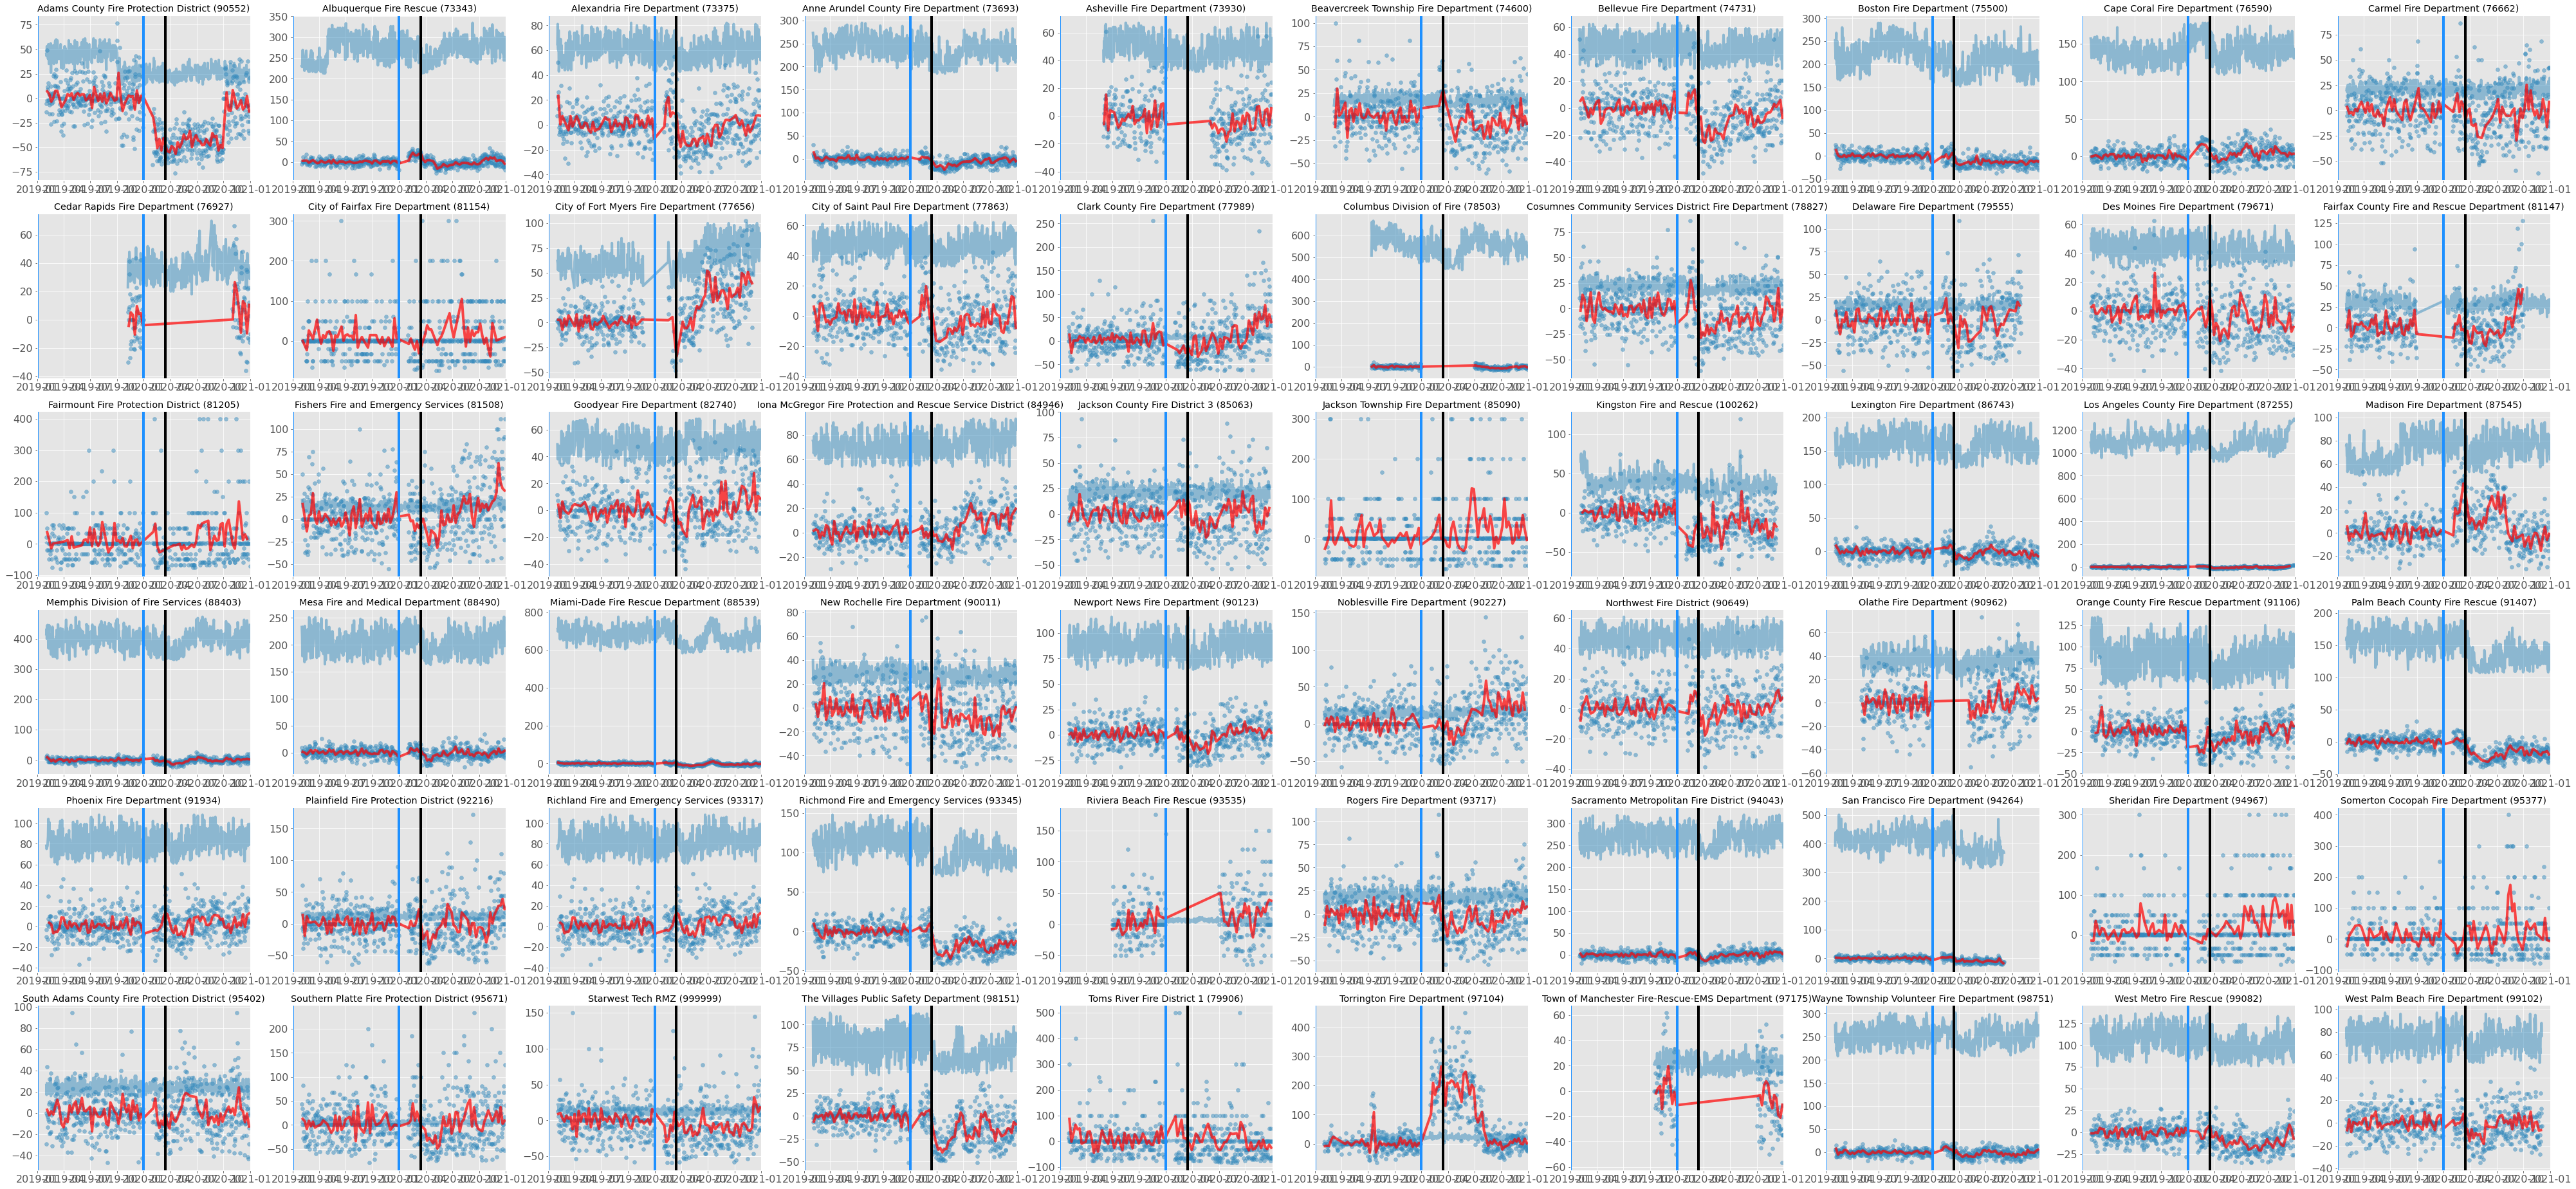

In [10]:
plt.figure(figsize=(70, 50))
i = 0
dept_keep = []
incident_dfs = []
for n, dept in tqdm(enumerate(depts.groups.keys())):
    df_dept = depts.get_group(dept)
    filter_out_no_2019_data(df_dept)
    if filter_out_no_2019_data(df_dept):
        plt.subplot(9, 10, i + 1)
        i = i + 1
        df_dept = remove_gaps(df_dept)
        df_dept = remove_outliers(df_dept, dept)
        average, merged_df = calculate_incident_type_weekly_avg(df_dept)
        plt.plot(pd.to_datetime(df_dept['date']), df_dept['count'], alpha=.5)
        plt.scatter(pd.to_datetime(merged_df['date']), merged_df['change_from_baseline'], alpha=.5)
        plt.plot(pd.to_datetime(average['date']), average['avg_last_7_days'], alpha=.7, color='red')
        
        
        incident_dfs.append(average)
        dept_keep.append(dept)          
    plt.title(dept)
    plt.xlim(left=pd.to_datetime('2019-1-1'))
    plt.xlim(right=pd.to_datetime('2021-1-1'))
    plt.axvline(x=pd.to_datetime('2020-3-15'),color='black')
    plt.axvline(x=pd.to_datetime('2020-1-1'),color='dodgerblue')
    plt.axvline(x=pd.to_datetime('2019-1-1'),color='dodgerblue')
    
    
#plt.savefig('wack.png', dpi=300)

In [21]:
df_2020_google = pd.read_csv('../data/google_data/2020_US_Region_Mobility_Report.csv')

def get_mobility_data(df, data_type):
    mobility_df = df[['date', data_type]]
    mobility_df['avg_last_7_days'] = mobility_df[data_type].rolling(window=7, min_periods=1).mean(skipna=True)
    mobility_df['day_of_week'] = mobility_df['date'].apply(lambda x: pd.to_datetime(x).day_name())
    first_day_of_week = 'Monday'
    weekly_mobility = mobility_df[mobility_df['day_of_week']==first_day_of_week]
    weekly_mobility['date'] = pd.to_datetime(weekly_mobility['date'])
    weekly_mobility = weekly_mobility[['date', 'avg_last_7_days']]
    weekly_mobility.columns = ['date', data_type]
    return weekly_mobility

In [28]:
mobility_dfs = []
for dept in tqdm(dept_keep):
    fips = final_df[final_df['department_name'] == dept]['fips']
    df_county = df_2020_google[df_2020_google['census_fips_code'] == int(fips)]
    mob_type_dfs = []
    for mob_type in df_2020_google.columns[9:]:#:
        mobility_county = get_mobility_data(df_county, mob_type)
        mob_type_dfs.append(mobility_county)
    all_types = pd.concat(mob_type_dfs, join='inner', axis=1)
    all_types= all_types.loc[:,~all_types.columns.duplicated()]
    mobility_dfs.append(all_types)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.15it/s]


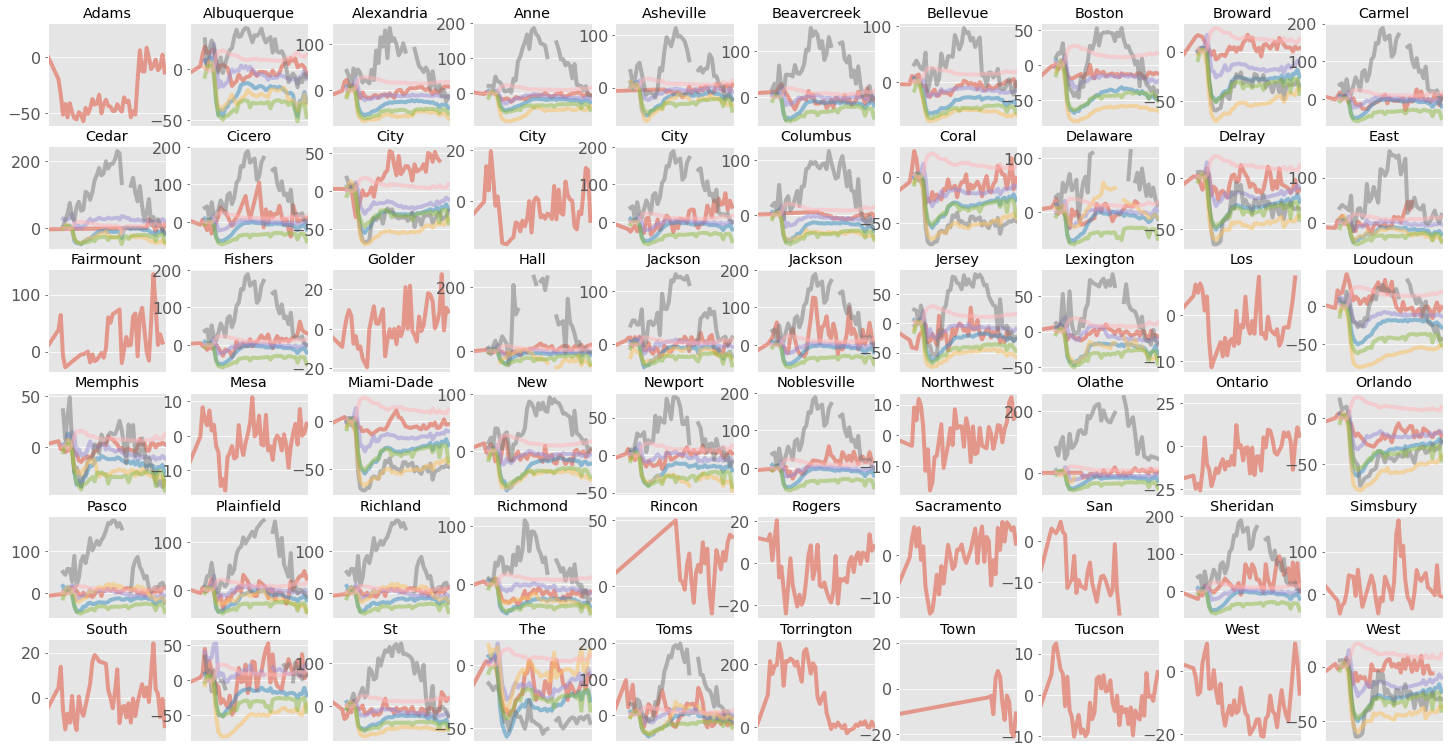

In [45]:
plt.figure(figsize=(25, 20))
type_mobility = 'workplaces_percent_change_from_baseline'
for n in range(len(dept_keep)):
    plt.subplot(9, 10, n + 1)
    plt.title(dept_keep[n].split(' ')[0])
    plt.plot(pd.to_datetime(incident_dfs[n]['date']), incident_dfs[n]['avg_last_7_days'], alpha=.5)
    plt.plot(pd.to_datetime(mobility_dfs[n]['date']), mobility_dfs[n][df_2020_google.columns[9:]], alpha=.5)  
    plt.xlim(left=pd.to_datetime('2020-1-1'))
    plt.xlim(right=pd.to_datetime('2021-1-1'))
    plt.xticks([])

In [46]:
non_empty_df = [df for df in mobility_dfs if df.empty == False]

In [47]:
final_mobility = [mobility_dfs[i] for i in range(len(dept_keep)) if mobility_dfs[i].empty == False]
final_incident = [incident_dfs[i] for i in range(len(dept_keep)) if mobility_dfs[i].empty == False]
final_depts = [dept_keep[i] for i in range(len(dept_keep)) if mobility_dfs[i].empty == False]


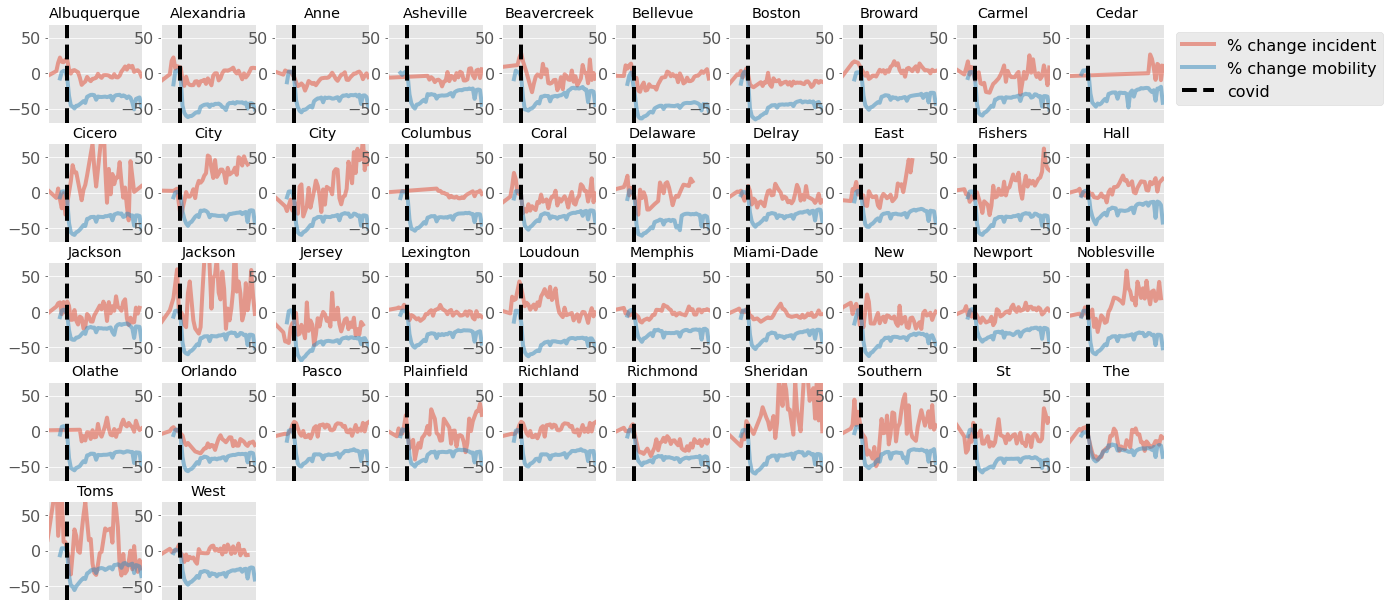

In [49]:
plt.figure(figsize=(20, 15))
for n in range(len(final_incident)):
    plt.subplot(7, 10, n + 1)
    plt.plot(pd.to_datetime(final_incident[n]['date']), final_incident[n]['avg_last_7_days'], alpha=.5, label='% change incident')
    plt.plot(pd.to_datetime(final_mobility[n]['date']), final_mobility[n][type_mobility], alpha=.5, label='% change mobility')  
    plt.xlim(left=pd.to_datetime('2020-1-1'))
    plt.xlim(right=pd.to_datetime('2021-1-1'))
    plt.xticks([])
    plt.ylim(-70,70)
    plt.title(final_depts[n].split(' ')[0])
    plt.axvline(x=pd.to_datetime('2020-3-15'),color='black', linestyle='--', label='covid')
    if n == 0:
        plt.legend(bbox_to_anchor=(14.2,1))
plt.savefig('wack.png', dpi=100, bbox_inches='tight')

In [56]:
combined_dfs = []
for i in range (len(final_mobility)):
    df_combined = pd.merge(final_mobility[i], final_incident[i], on='date', how='inner')
    df_combined = df_combined.rename(columns={'avg_last_7_days': 'incidents'})
    combined_dfs.append(df_combined)

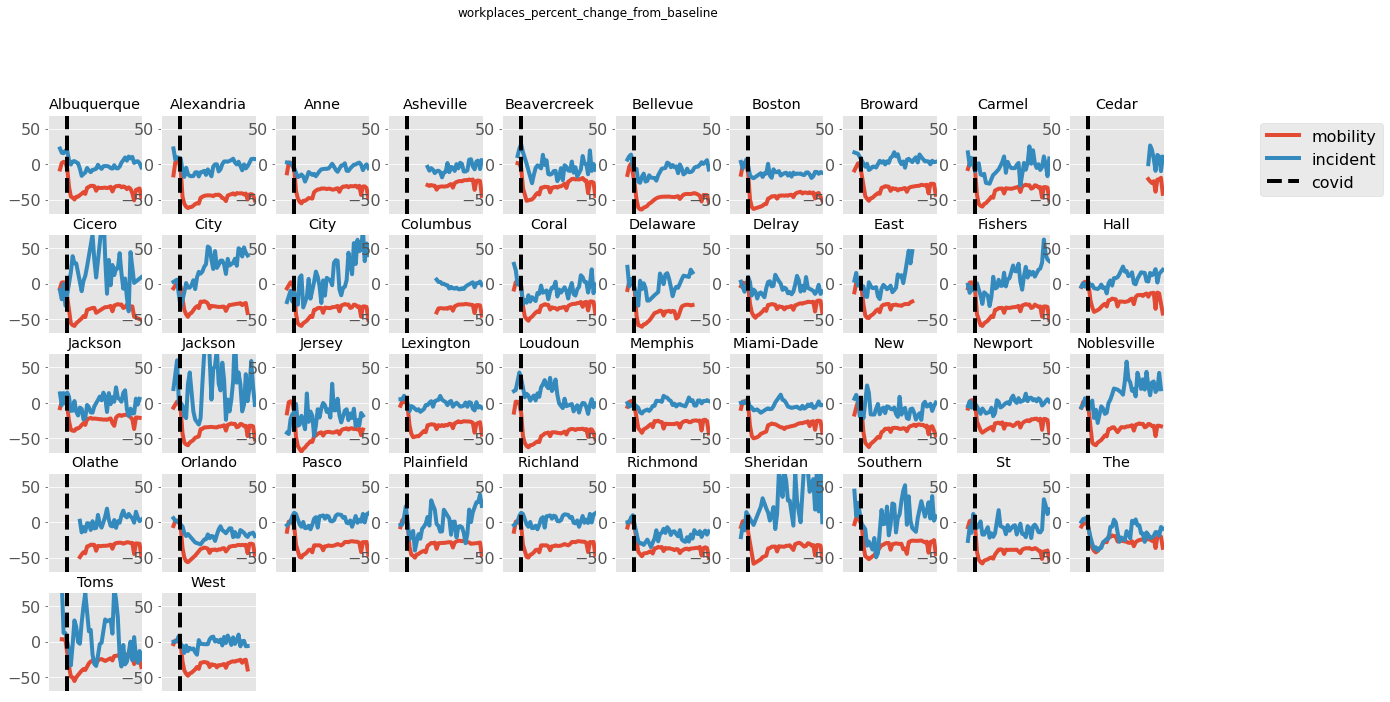

In [70]:
plt.figure(figsize=(20, 15))
type_mobility = df_2020_google.columns[9:][4]

for n in range(len(combined_dfs)):
    plt.subplot(7, 10, n + 1)
    plt.plot(combined_dfs[n]['date'], combined_dfs[n][type_mobility], label='mobility')
    plt.plot(combined_dfs[n]['date'], combined_dfs[n]['incidents'], label='incident')
    
    plt.xlim(left=pd.to_datetime('2020-1-1'))
    plt.xlim(right=pd.to_datetime('2021-1-1'))
    plt.xticks([])
    plt.ylim(-70,70)
    plt.title(final_depts[n].split(' ')[0])
    plt.axvline(x=pd.to_datetime('2020-3-15'),color='black', linestyle='--', label='covid')
    if n == 0:
        plt.legend(bbox_to_anchor=(14.2,1))
plt.suptitle(type_mobility);

In [9]:
def remove_gaps(input_df, gap_threshold=2):
        """
        Takes in a dataframe of dates/counts and returns one without gaps,
        i.e. intervals of more than gap_threshold consecutive zero-incident
        days.
        Parameters
        ----------
        input_df: pandas.DataFrame
                Input dataframe with dates and incident counts
        gap_threshold:	int
                The number of consecutive zero call days required to be identified
                as a gap
        Returns
        -------
        result_df: pandas.DataFrame
                The input_df with all gaps removed
        """
        df = input_df.copy()

        # This new column takes value 1 if there are zero calls and 0 otherwise
        df['zero_mask'] = (df['count'] == 0).astype(int)

        # This new column breaks the dataframe into groups
        # Basically, we start at the beginning, and every time we go
        # from 0 calls to >0 calls, we start a new group
        df['group'] = (df['zero_mask'].diff(1) == -1).astype('int').cumsum()

        # Subset of df with only zero incident days
        zero_df = df[df['count'] == 0].reset_index(drop=True)

        # Getting the size of each group
        group_results = zero_df.groupby('group').size().reset_index(
            name='size')

        # Any group larger than gap_threshold is represents more
        # than gap_threshold days in a row with 0 incidents
        groups_to_exclude = group_results[
            group_results['size'] >= gap_threshold]['group'].values

        # All the zero incident days in a group that
        # contains a gap are excluded
        dates_to_exclude = zero_df[zero_df['group'].isin(
            groups_to_exclude)]['date']

        result_df = input_df[~input_df['date'].isin(dates_to_exclude
                                                    )].reset_index(drop=True)

        return result_df

In [183]:
calculate_incident_type_weekly_avg(df_dept)

date  count                          department_name  year  month  \
93393 2019-02-01     75  West Palm Beach Fire Department (99102)  2019      2   
93394 2019-02-02     84  West Palm Beach Fire Department (99102)  2019      2   
93395 2019-02-03     68  West Palm Beach Fire Department (99102)  2019      2   
93396 2019-02-04     75  West Palm Beach Fire Department (99102)  2019      2   
93397 2019-02-05     75  West Palm Beach Fire Department (99102)  2019      2   
...          ...    ...                                      ...   ...    ...   
94541 2022-03-25      0  West Palm Beach Fire Department (99102)  2022      3   
94542 2022-03-26      0  West Palm Beach Fire Department (99102)  2022      3   
94543 2022-03-27      0  West Palm Beach Fire Department (99102)  2022      3   
94544 2022-03-28      0  West Palm Beach Fire Department (99102)  2022      3   
94545 2022-03-29      0  West Palm Beach Fire Department (99102)  2022      3   

      day_of_week  
93393      Friday  
93394    Saturday  
93395      Sunday  
93396      Monday  
93397     Tuesday  
...           ...  
94541      Friday  
94542    Saturday  
94543      Sunday  
94544      Monday  
94545     Tuesday  

[1153 rows x 6 columns]

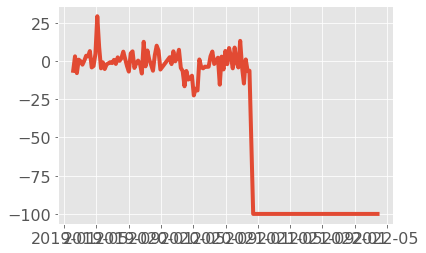

In [164]:
plt.plot(weekly_counts_cleaned['date'], weekly_counts_cleaned['avg_last_7_days'])